In [1]:
%load_ext autoreload
%autoreload 2

# Verify conditional circuit generation

We have previously trained a neural network known as a conditional variational autoencoder on genetic circuits. The conditioning variable was made to be one of the characteristics of the genetic circuit's dynamics, for example the sensitivity of the circuit to a signal. While the distributions for each class of conditional variables differ in the AI-generated circuits, the verification of their ground-truth label is still necessary to assess the validity of the conditionality.

## Imports

In [2]:
from synbio_morpher.srv.io.manage.script_manager import script_preamble
from synbio_morpher.srv.parameter_prediction.simulator import RawSimulationHandling, make_piecewise_stepcontrol
from synbio_morpher.utils.results.analytics.timeseries import generate_analytics
from synbio_morpher.utils.common.setup import prepare_config, expand_config, expand_model_config
from synbio_morpher.utils.data.data_format_tools.common import load_json_as_dict
from synbio_morpher.utils.results.analytics.naming import get_true_interaction_cols
from synbio_morpher.utils.data.data_format_tools.common import write_json
from synbio_morpher.utils.misc.numerical import symmetrical_matrix_length, make_symmetrical_matrix_from_sequence
from synbio_morpher.utils.misc.string_handling import prettify_keys_for_label
from synbio_morpher.utils.misc.type_handling import flatten_listlike, get_unique
from synbio_morpher.utils.modelling.deterministic import bioreaction_sim_dfx_expanded
from bioreaction.simulation.simfuncs.basic_de import bioreaction_sim, bioreaction_sim_expanded
from bioreaction.model.data_tools import construct_model_fromnames
from bioreaction.model.data_containers import BasicModel, QuantifiedReactions
from bioreaction.simulation.manager import simulate_steady_states
from functools import partial

from scipy.cluster.vq import whiten
from scipy.special import factorial
from sklearn.metrics import r2_score  
from sklearn.manifold import TSNE
import os
import sys
import numpy as np
import haiku as hk
import jax
import diffrax as dfx

from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
                
import wandb

from datetime import datetime
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

jax.config.update('jax_platform_name', 'gpu')


# if __package__ is None:

module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)

__package__ = os.path.basename(module_path)


jax.devices()

rng = jax.random.PRNGKey(0)


/home/wadh6511/Kode/env_evo/lib/python3.10/site-packages/jaxtyping/__init__.py:221: UserWarning: jaxtyping version >=0.2.23 should be used with Equinox version >=0.11.1
  warnings.warn(
I0000 00:00:1707141485.456948  218986 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
xla_bridge.py:backends():513: Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: CUDA INFO
xla_bridge.py:backends():513: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory INFO


In [3]:
from src.models.vae import CVAE, sample_z
from src.models.mlp import MLP
from src.models.shared import arrayise
from src.losses.losses import loss_wrapper, compute_accuracy_regression, mse_loss
from src.utils.data_preprocessing import drop_duplicates_keep_first_n

## Load data

In [4]:
fn = '../data/processed/ensemble_mutation_effect_analysis/2023_07_17_105328/tabulated_mutation_info.csv'
fn_test_data = '../data/raw/ensemble_mutation_effect_analysis/2023_10_03_204819/tabulated_mutation_info.csv'
data = pd.read_csv(fn)
try:
    data.drop(columns=['Unnamed: 0'], inplace=True)
except:
    pass

## Load model

### Hyperparameters

In [5]:
# Architecture
HIDDEN_SIZE = 32 # 64
ENC_LS = 64
DEC_LS = 64
NUM_ENC_LAYERS = 3
NUM_DEC_LAYERS = 3
enc_layers = [ENC_LS] * NUM_ENC_LAYERS # [128, 128, 64, 64] # 
dec_layers = [DEC_LS] * NUM_DEC_LAYERS # [64, 64, 128, 128] # 


BATCH_SIZE = 128
N_BATCHES = 1200
TOTAL_DS = BATCH_SIZE * N_BATCHES
MAX_TOTAL_DS = TOTAL_DS
TRAIN_SPLIT = 0.8
SCALE_X = False
USE_X_LOGSCALE = True
X_TYPE = 'binding_rates_dissociation' #  'energies' #
LEARNING_RATE = 5e-4
LEARNING_RATE_SCHED = 'cosine_decay'
# LEARNING_RATE_SCHED = 'constant'
WARMUP_EPOCHS = 20
L2_REG_ALPHA = 0.01
EPOCHS = 1000
PRINT_EVERY = EPOCHS // 100
SEED = 1

INPUT_SPECIES = 'RNA_1'
USE_CATEGORICAL = False
target_circ_func = 'sensitivity_wrt_species-6'
input_concat_diffs = False
input_concat_axis = 0

# Training
USE_DROPOUT = False
USE_L2_REG = False
USE_WARMUP = True
loss_fn = partial(
    loss_wrapper, loss_f=mse_loss, use_l2_reg=USE_L2_REG) 
compute_accuracy = compute_accuracy_regression

subtask = '_test'
save_path = str(datetime.now()).split(' ')[0].replace(
    '-', '_') + '__' + str(datetime.now()).split(' ')[-1].split('.')[0].replace(':', '_') + '_saves' + subtask
save_path = os.path.join('weight_saves', '10_cvae', save_path)

rng = jax.random.PRNGKey(SEED)

### Init data

In [6]:
filt = data['sample_name'] == INPUT_SPECIES

# Balance the dataset
df = data[filt]
df = drop_duplicates_keep_first_n(df, get_true_interaction_cols(
    data, X_TYPE, remove_symmetrical=True), n=100)

TOTAL_DS = np.min([TOTAL_DS, MAX_TOTAL_DS, len(df)])
N_BATCHES = TOTAL_DS // BATCH_SIZE
TOTAL_DS = N_BATCHES * BATCH_SIZE

x_cols = [get_true_interaction_cols(data, X_TYPE, remove_symmetrical=True)]
if input_concat_diffs:
    x_cols = x_cols + \
        [[f'{i}_diffs' for i in get_true_interaction_cols(
            data, X_TYPE, remove_symmetrical=True)]]

x = [df[i].iloc[:TOTAL_DS].values[:, :, None] for i in x_cols]
x = np.concatenate(x, axis=input_concat_axis+1).squeeze()

x_scaling, x_unscaling = [], []
if USE_X_LOGSCALE:
    x_scaling.append(np.log10)
    x_unscaling.append(lambda x: np.power(10, x))

if SCALE_X:
    xscaler = MinMaxScaler()
    x_scaling.append(xscaler.fit_transform)
    x_unscaling.append(xscaler.inverse_transform)

x_unscaling = x_unscaling[::-1]

for fn in x_scaling:
    x = fn(x)

    
cond = df[target_circ_func].iloc[:TOTAL_DS].to_numpy()

if USE_CATEGORICAL:
    from src.utils.math import convert_to_scientific_exponent

    vectorized_convert_to_scientific_exponent = np.vectorize(
        convert_to_scientific_exponent)
    numerical_resolution = 2
    cond_map = {k: numerical_resolution for k in np.arange(int(f'{cond[cond != 0].min():.0e}'.split(
        'e')[1])-1, np.max([int(f'{cond.max():.0e}'.split('e')[1])+1, 0 + 1]))}
    cond_map[-6] = 1
    cond_map[-5] = 1
    cond_map[-4] = 4
    cond_map[-3] = 2
    cond_map[-1] = 3
    cond = jax.tree_util.tree_map(partial(
        vectorized_convert_to_scientific_exponent, numerical_resolution=cond_map), cond)
    cond = np.interp(cond, sorted(np.unique(cond)), np.arange(
        len(sorted(np.unique(cond))))).astype(int)
else:
    zero_log_replacement = -10.0
    cond = np.where(cond != 0, np.log10(cond), zero_log_replacement)

cond = cond[:, None]
N_HEAD = x.shape[-1]

x, cond = shuffle(x, cond, random_state=SEED)

if x.shape[0] < TOTAL_DS:
    print(
        f'WARNING: The filtered data is not as large as the requested total dataset size: {x.shape[0]} vs. requested {TOTAL_DS}')

### Init model

In [38]:
def VAE_fn(enc_layers: list, dec_layers: list, call_kwargs: dict = {}):
    encoder = MLP(layer_sizes=enc_layers, n_head=dec_layers[0], use_categorical=False, name='encoder')
    decoder = MLP(layer_sizes=dec_layers, n_head=x.shape[-1], use_categorical=False, name='decoder')
    model = CVAE(encoder=encoder, decoder=decoder, embed_size=HIDDEN_SIZE)
    
    def init(x: np.ndarray, cond: np.ndarray, deterministic: bool):
        h = model.encoder(np.concatenate([x, cond], axis=-1))

        mu = model.h2mu(h)
        logvar = model.h2logvar(h)
        z = model.reparameterize(mu, logvar, hk.next_rng_key(), deterministic)
        z_cond = np.concatenate([z, cond], axis=-1)

        y = model.decoder(z_cond)
        return y
        
    return init, (encoder, decoder, model, model.h2mu, model.h2logvar, model.reparameterize)

model_fn = partial(VAE_fn, enc_layers=enc_layers, dec_layers=dec_layers)
# model = hk.transform(model_fn)
model_t = hk.multi_transform(model_fn)
params = model_t.init(rng, x, cond, deterministic=False)
encoder, decoder, model, h2mu, h2logvar, reparam = model_t.apply

/home/wadh6511/Kode/env_evo/lib/python3.10/site-packages/haiku/_src/initializers.py:126: UserWarning: Explicitly requested dtype float64  is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  unscaled = jax.random.truncated_normal(
/home/wadh6511/Kode/env_evo/lib/python3.10/site-packages/haiku/_src/base.py:682: UserWarning: Explicitly requested dtype float64 requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  param = init(shape, dtype)


In [37]:
model_t

MultiTransformed(init=<function without_state.<locals>.init_fn at 0x7fa08d7a45e0>, apply=(<function without_state.<locals>.apply_without_state.<locals>.apply_fn at 0x7fa08d7a4700>, <function without_state.<locals>.apply_without_state.<locals>.apply_fn at 0x7fa08d7a49d0>, <function without_state.<locals>.apply_without_state.<locals>.apply_fn at 0x7fa08d7a4b80>))

In [33]:
fn_saves = os.path.join('weight_saves', '10_cvae', '2023_12_14__11_37_03_saves_test')
fn_saves = os.path.join('weight_saves', '10_cvae', '2023_12_20__23_24_49_saves_hiddens64')
fn_saves = os.path.join('weight_saves', '10_cvae', '2023_12_21__14_46_08_saves_hs64_ls4_e2000')
fn_saves = os.path.join('weight_saves', '10_cvae', '2023_12_21__14_18_00_saves_alldata')
fn_saves = os.path.join('weight_saves', '10_cvae', '2024_02_04__15_54_15_saves_test')
saves_loaded = load_json_as_dict(fn_saves)

p = saves_loaded[str(list(saves_loaded.keys())[-1])]['params']
p = arrayise(p)

### Sample circuits

In [9]:
np.random.rand()

0.771222500385871

In [10]:
n_to_sample = 10000
cond_splits = 10
sampled_cond = np.interp(np.random.rand(
    n_to_sample//cond_splits, cond.shape[-1]), [0, 1], np.linspace(cond.min(), cond.max(), cond_splits)[0:2])[None, :]
for i in range(1, cond_splits):
    sampled_cond0 = np.interp(np.random.rand(
        n_to_sample//cond_splits, cond.shape[-1]), [0, 1], np.linspace(cond.min(), cond.max(), cond_splits+1)[i:i+2])[None, :]
    sampled_cond = np.concatenate([sampled_cond, sampled_cond0], axis=0)
mu = np.random.normal(size=(n_to_sample, HIDDEN_SIZE))
logvar = np.random.normal(size=(n_to_sample, HIDDEN_SIZE))
z = sample_z(mu=mu, logvar=logvar, key=rng)
z = np.concatenate([z, sampled_cond.reshape(np.prod(sampled_cond.shape[:-1]), sampled_cond.shape[-1])], axis=-1)

fake_circuits = decoder(p, rng, z)
# fake_circuits = np.where(fake_circuits > 0, 0, fake_circuits)
sampled_cond.shape

(10, 1000, 1)

Text(0.5, 1.0, 'Sampled conditioning variable (log sensitivity)')

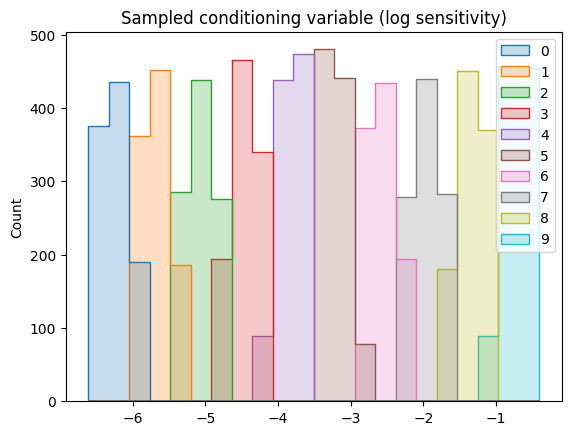

In [11]:
sns.histplot(sampled_cond.squeeze().T, element='step')
plt.title('Sampled conditioning variable (log sensitivity)')

# Simulate 

## Construct circuits

### Config

In [12]:
run_intarna = True

config = {
    "system_type": "RNA",
    "include_prod_deg": False,
    "data": {},
    "experiment": {
        "purpose": "tests",
        "debug_mode": False
    },
    "interaction_simulator": {
        "name": "IntaRNA",
        "postprocess": True,
        "simulator_kwargs": {
            "outcsvcols": "id1, id2, E, E_norm, bpList, hybridDPfull, seedPu1, seedPu2, seedStart1, seedStart2, seedEnd1, seedEnd2",
            "threads": 12,
            "n": 1,
            "raw_stdout": True
        }
    },
    "molecular_params_factor": 1,
    "molecular_params": {
        "avg_mRNA_per_cell": 100,
        "cell_doubling_time": 1200,
        "creation_rate": 2.35,
        "starting_copynumbers": 200,
        "degradation_rate": 0.01175,
        "association_binding_rate": 1000000
    },
    "signal": {
        "inputs": ["RNA_0"],
        "outputs": ["RNA_1"],
        "function_name": "step_function",
        "function_kwargs": {
            "impulse_center": 1, 
            "impulse_halfwidth": 5, 
            "target": 2
        }
    },
    "simulation": {
        "dt0": 0.1,
        "t0": 0,
        "t1": 100,
        "tmax": 2000,
        "solver": "diffrax",
        "use_batch_mutations": True,
        "interaction_factor": 1,
        "batch_size": 20000,
        "max_circuits": 60000,
        "device": "gpu",
        "threshold_steady_states": 0.05, 
        "use_rate_scaling": True
    },
    "system_type": "RNA",
}


if run_intarna:
    data_writer = None
    config, data_writer = script_preamble(config, data_writer)
    config = prepare_config(expand_config(config=config))

### Circuits

In [13]:
def make_symmetrical_matrix_from_sequence_nojax(arr, side_length: int):
    """ For a flat 1D array, make a symmetrical 2D matrix filling
    in the upper triangle with the 1D array. Not jax-friendly. """
    n = np.zeros((side_length, side_length))
    n[np.triu_indices(side_length)] = arr
    return n

def update_species_simulated_rates(ordered_species: list, forward_interactions, reverse_interactions, model: BasicModel, qreactions: QuantifiedReactions):
    for i, r in enumerate(model.reactions):
        if len(r.input) == 2:
            model.reactions[i].forward_rate = forward_interactions[
                ordered_species.index(r.input[0]), ordered_species.index(r.input[1])]
            
            model.reactions[i].reverse_rate = reverse_interactions[
                ordered_species.index(r.input[0]), ordered_species.index(r.input[1])]
    qreactions.reactions = qreactions.init_reactions(
        model)
    return model, qreactions

Reshape the generated circuit energies into a 3x3 symmetrical matrix.

In [14]:
num_species = symmetrical_matrix_length(fake_circuits.shape[-1])
input_species = [f'RNA_{i}' for i in range(num_species)]
config.update(expand_model_config(config, {}, input_species))
fake_circuits_reshaped = np.array(list(map(partial(make_symmetrical_matrix_from_sequence_nojax, side_length=num_species), fake_circuits)))
for fn in x_unscaling:

    fake_circuits_reshaped = fn(fake_circuits_reshaped)
    
fake_circuits_reshaped = np.where(fake_circuits_reshaped > df[x_cols[0]].max().max(), df[x_cols[0]].max().max(), fake_circuits_reshaped)

Initialise barebones circuit models

In [16]:
model_brn = construct_model_fromnames(sample_names=input_species, include_prod_deg=config['include_prod_deg'])
ordered_species = sorted(get_unique(flatten_listlike([r.input for r in model_brn.reactions if r.output])))
signal_species = ['RNA_0']
output_species = ['RNA_1', 'RNA_2']
qreactions = QuantifiedReactions()
qreactions.init_properties(model_brn, config['starting_concentration'])
for i in range(len(model_brn.reactions)):
    model_brn.reactions[i].forward_rate = 0
    model_brn.reactions[i].reverse_rate = 0
    if (not model_brn.reactions[i].input) and config['include_prod_deg']:
        model_brn.reactions[i].forward_rate = config['molecular_params'].get(
            'creation_rate')
    elif (not model_brn.reactions[i].output) and config['include_prod_deg']:
        model_brn.reactions[i].forward_rate = config['molecular_params'].get(
            'degradation_rate')
        

reactant_species = [
    r.species for r in qreactions.reactants]
quantities = [r.quantity for r in qreactions.reactants if r.species.name in input_species]
postproc = RawSimulationHandling(config['interaction_simulator']).get_postprocessing(initial=quantities)
eqconstants, (a_rates, d_rates) = postproc(fake_circuits_reshaped[0])
model_brn, qreactions = update_species_simulated_rates(ordered_species, a_rates, d_rates, model_brn, qreactions)


/home/wadh6511/Kode/env_evo/src/synbio-morpher/synbio_morpher/utils/modelling/physical.py:58: RuntimeWarning: overflow encountered in divide
  k_d = np.divide(k_a, eqconstants)


## Run simulator

In [17]:
def compute_analytics(y, t, labels, signal_onehot):
    y = np.swapaxes(y, 0, 1)

    analytics_func = partial(
        generate_analytics, time=t, labels=labels,
        signal_onehot=signal_onehot, signal_time=t[1],
        ref_circuit_data=None)
    return analytics_func(data=y, time=t, labels=labels)


def sim(y00, forward_rates, reverse_rates,
        qreactions,
        signal_onehot, signal_target,
        t0, t1, dt0, dt1,
        save_steps, max_steps):
    sim_func = jax.jit(jax.vmap(partial(bioreaction_sim_dfx_expanded,
                                t0=t0, t1=t1, dt0=dt0,
                                signal=None, signal_onehot=None,
                                inputs=qreactions.reactions.inputs,
                                outputs=qreactions.reactions.outputs,
                                forward_rates=forward_rates,
                                solver=dfx.Tsit5(),
                                saveat=dfx.SaveAt(
                                    ts=np.linspace(t0, t1, save_steps)),
                                max_steps=max_steps,
                                stepsize_controller=make_piecewise_stepcontrol(
                                    t0=t0, t1=t1, dt0=dt0, dt1=dt1)
                                )))
    """ Concentrations should be in the form [circuits, time, species] """

    y00s, ts0 = simulate_steady_states(y0=y00, total_time=t1-t0, sim_func=sim_func, t0=t0,
                                   t1=t1, threshold=0.05, reverse_rates=reverse_rates, disable_logging=True)
    y0 = np.array(y00s[:, -1, :]).reshape(y00.shape)
    print('Steady states found. Now calculating signal response')

    # Signal
    y0m = y0 * ((signal_onehot == 0) * 1) + y00 * signal_target * signal_onehot
    ys, ts = simulate_steady_states(y0m, total_time=t1-t0, sim_func=sim_func, t0=t0,
                                  t1=t1, threshold=0.05, reverse_rates=reverse_rates, disable_logging=True)
    ys = np.concatenate([y0, ys.squeeze()[:, :-1, :]], axis=1)

    analytics = jax.vmap(partial(compute_analytics, t=ts, labels=np.arange(
        ys.shape[-1]), signal_onehot=signal_onehot))(ys)

    return analytics, ys, ts, y0m, y00s, ts0

In [18]:
eqconstants, (forward_rates, reverse_rates) = postproc(fake_circuits_reshaped)
if 'binding_rates_dissociation' in x_cols[0][0]:
    reverse_rates = fake_circuits_reshaped
    eqconstants = forward_rates[0, 0, 0] / reverse_rates

signal_onehot = np.where([r.species.name in signal_species for r in qreactions.reactants], 1, 0)
forward_rates, reverse_rates = np.array(list(map(lambda i: i[np.triu_indices(n=forward_rates.shape[-1])], forward_rates))), np.array(list(map(lambda i: i[np.triu_indices(n=reverse_rates.shape[-1])], reverse_rates)))
signal_target = 2
y00 = np.repeat(np.array([r.quantity for r in qreactions.reactants])[None, None, :], repeats=len(fake_circuits_reshaped), axis=0)
t0, t1, dt0, dt1 = 0, 100, 0.001, 0.0008
save_steps, max_steps = 50, 16**5

analytics, ys, ts, y0m, y00s, ts0 = sim(y00, forward_rates[0], reverse_rates,
    qreactions,
    signal_onehot, signal_target,
    t0, t1, dt0, dt1,
    save_steps, max_steps)

Steady states found. Now calculating signal response


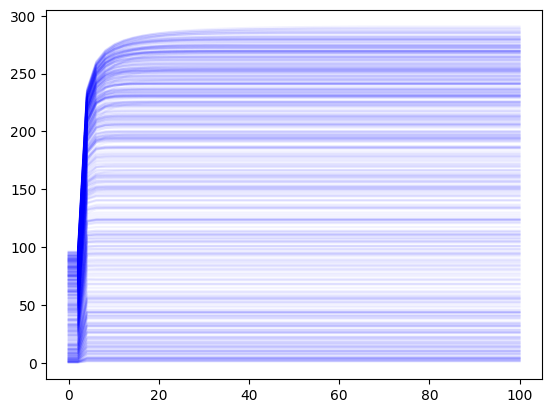

In [19]:
plt.plot(np.repeat(ts[None, :], repeats=500, axis=0).T, ys[:500, :, 0].T, alpha=0.05, color='b')
plt.show()
plt.close()

In [20]:
analytics['sensitivity_wrt_species-6'].shape

(10000, 9)

In [21]:
analytics['sensitivity_wrt_species-6'].reshape(cond_splits, np.prod(analytics['sensitivity_wrt_species-6'].shape)//cond_splits).shape

(10, 9000)

# Visualise

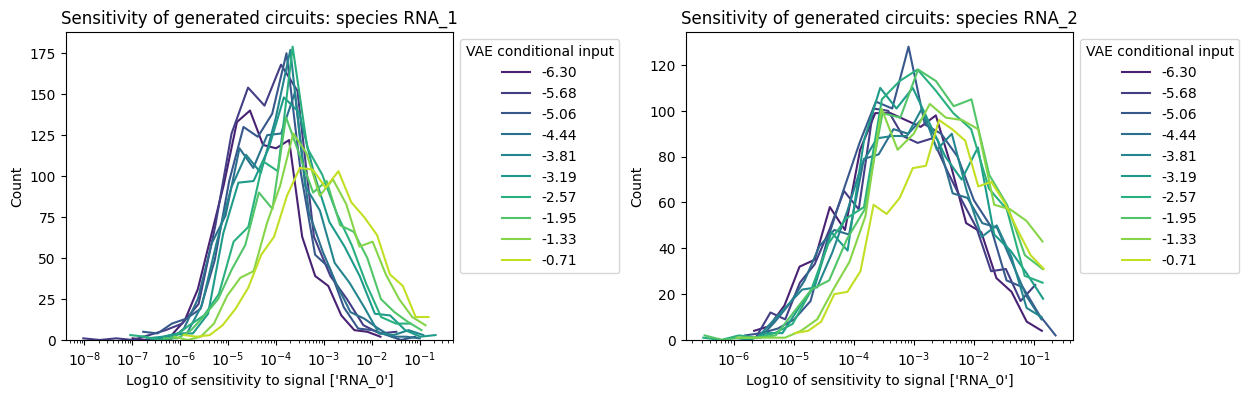

In [22]:
fig = plt.figure(figsize=(13, 4))
fig.subplots_adjust(wspace=0.6)
for i, output_specie in enumerate(output_species):
    output_idx = [s.name for s in model_brn.species].index(output_species[i])

    s = analytics['sensitivity_wrt_species-6']
    s = np.where(s == 0, 1e-7, s)

    ax = plt.subplot(1, 2, i+1)
    pal = sns.color_palette('viridis', cond_splits)
    sample_conds_ave = np.mean(np.array([np.linspace(cond.min(), cond.max(
    ), cond_splits+1)[i:m+2] for i, m in zip(range(2), range(cond_splits-2, cond_splits+1))]), axis=0)
    for i in range(cond_splits):
        sns.histplot(analytics['sensitivity_wrt_species-6'][i*n_to_sample//cond_splits:(i+1) *
                    n_to_sample//cond_splits, output_idx],  element='poly', log_scale=[True, False],
                    kde=False, fill=False, color=pal[i], bins=20, label=f'{str(sample_conds_ave[i])[:5]}')
        # plt.vlines(np.percentile(analytics['sensitivity_wrt_species-6'][i*n_to_sample//cond_splits:(i+1) * n_to_sample//cond_splits,
        #            output_idx], q=50), ymin=0, ymax=170, color=sns.color_palette('viridis', n_colors=cond_splits)[i], linestyles='dashed')
    # sns.histplot(s.reshape(cond_splits, np.prod(s.shape)//cond_splits).T, element='step', log_scale=[True, False], kde=True, fill=False)
    # plt.vlines(np.percentile(analytics['sensitivity_wrt_species-6']
    #            [:n_to_sample//2, output_idx], q=[25, 50, 75]), ymin=0, ymax=350)
    # ax2 = plt.subplot(1,2,2, sharex=ax)
    # sns.histplot(analytics['sensitivity_wrt_species-6'][n_to_sample//2:,
    #              output_idx], element='step', log_scale=[True, False], kde=True)
    # plt.vlines(np.percentile(analytics['sensitivity_wrt_species-6'][n_to_sample //
    #            2:, output_idx], q=[25, 50, 75]), ymin=0, ymax=350, color='orange')
    # plt.vlines(np.power(10, sample_conds_ave), ymin=0, ymax=170, color=sns.color_palette(
    #     'viridis', n_colors=cond_splits), linestyles='dashed')

    plt.legend(title='VAE conditional input')
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    plt.title(f'Sensitivity of generated circuits: species {output_specie}')
    plt.xlabel(f'Log10 of sensitivity to signal {signal_species}')

Diffs: [ 3.07273875  2.51420151  1.97632704  1.36853509  0.78875652  0.18695906
 -0.31476018 -0.80484897 -1.29971218 -1.79224545] 14.11908475713632


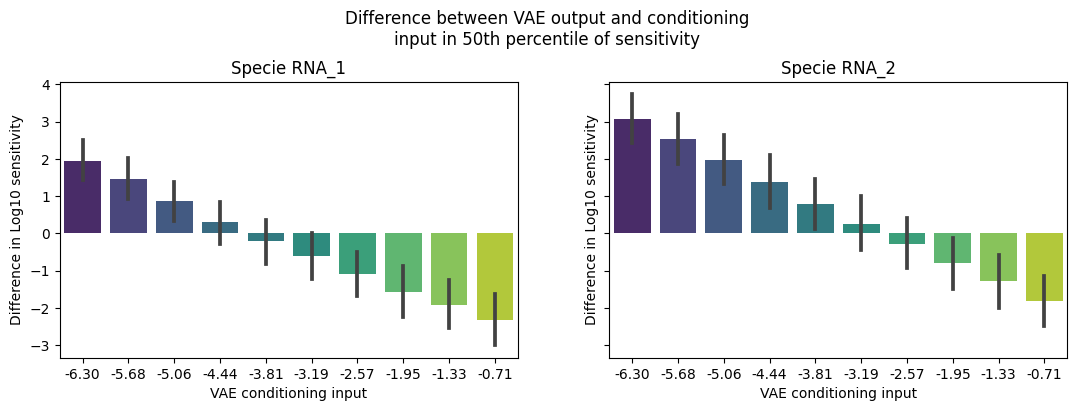

In [23]:
# fig = plt.figure(figsize=(13, 4))
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(13, 4))
fig.subplots_adjust(hspace=0.3, top=0.8)
for i, output_specie in enumerate(output_species):
    output_idx = [s.name for s in model_brn.species].index(output_species[i])

    diffs_conditional_real_sens = np.log10(np.array([np.percentile(
        analytics['sensitivity_wrt_species-6'][i*n_to_sample//cond_splits:(i+1) * n_to_sample//cond_splits, output_idx], 
        q=[25, 50, 75]) for i in range(cond_splits)])) - sample_conds_ave[:, None]

    plt.axes(axs[i])
    sns.barplot(pd.DataFrame(diffs_conditional_real_sens.T, columns=[
                str(i)[:5] for i in sample_conds_ave]), palette='viridis', ax=axs[i])
    plt.xlabel('VAE conditioning input')
    plt.ylabel('Difference in Log10 sensitivity')
    plt.title(f'Specie {output_specie}')

plt.suptitle('Difference between VAE output and conditioning\ninput in 50th percentile of sensitivity')
print('Diffs:', diffs_conditional_real_sens[:, 1], np.sum(np.abs(diffs_conditional_real_sens[:, 1])))

Text(0.5, 0.98, 'Generated circuits: sensitivity vs. precision')

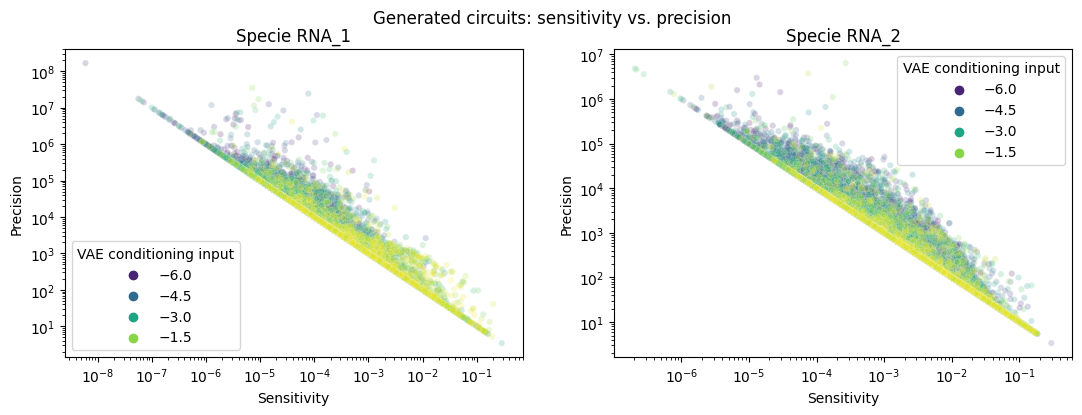

In [24]:

# fig, axs = plt.subplots(1, 2, sharey=True, figsize=(13, 4))
fig = plt.figure(figsize=(13, 4))
# fig.subplots_adjust(hspace=0.3, top=0.8)
for i, output_specie in enumerate(output_species):
    output_idx = [s.name for s in model_brn.species].index(output_species[i])
    d = pd.DataFrame()
    d['Sensitivity'] = analytics['sensitivity_wrt_species-6'][:, output_idx]
    d['Precision'] = analytics['precision_wrt_species-6'][:, output_idx]
    d['VAE conditioning input'] = sampled_cond.flatten()
    ax = plt.subplot(1,2,i+1)
    sns.scatterplot(d, x='Sensitivity', y='Precision', alpha=0.2, hue='VAE conditioning input', palette='viridis', s=20)
    plt.xscale('log')
    plt.yscale('log')
    plt.title(f'Specie {output_specie}')
plt.suptitle('Generated circuits: sensitivity vs. precision')
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

# Cluster predictions

## TSNE

In [108]:
h = encoder(p, rng, np.concatenate([x, cond], axis=-1))

mu = h2mu(p, rng, h)
logvar = h2logvar(p, rng, h)
z = reparam(p, rng, mu, logvar, rng, deterministic=True)
z_cond = np.concatenate([z, cond], axis=-1)

tsne_inp = whiten(z_cond[:10000])
        
n_components = 2
tsne = TSNE(n_components, perplexity=300, learning_rate=100, n_iter=500)
tsne_result = tsne.fit_transform()
tsne_result.shape


(10000, 2)

In [110]:
# n_components = 2
# tsne = TSNE(n_components, perplexity=300, learning_rate=100, n_iter=500)
# tsne_result = tsne.fit_transform(fake_circuits)
# tsne_result.shape

### Visualise TSNE

Text(0.5, 0.98, 'TSNE Generated circuits')

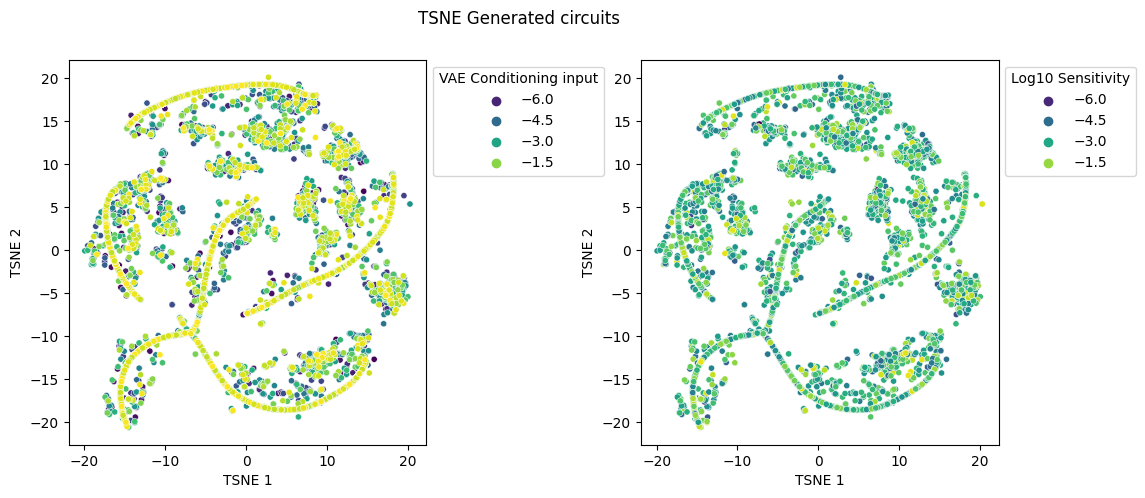

In [111]:
fig = plt.figure(figsize=(12, 5))
fig.subplots_adjust(wspace=0.6)
# for i in range(n_components):
#     for j in range(i, n_components):
tsne_result_df = pd.DataFrame({'TSNE 1': tsne_result[:, 0], 'TSNE 2': tsne_result[:, 1], 'VAE Conditioning input': sampled_cond.flatten()[:10000], 'Log10 Sensitivity': np.log10(analytics['sensitivity_wrt_species-6'][:, output_idx][:10000])})
ax = plt.subplot(1,int(factorial(n_components)),1)
sns.scatterplot(x='TSNE 1', y='TSNE 2', hue='VAE Conditioning input', data=tsne_result_df, s=20, palette='viridis', alpha=1)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax = plt.subplot(1,int(factorial(n_components)),2)
sns.scatterplot(x='TSNE 1', y='TSNE 2', hue='Log10 Sensitivity', data=tsne_result_df, s=20, palette='viridis', alpha=1)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.suptitle('TSNE Generated circuits')

In [ ]:
tsne_result2 = tsne.fit_transform(data[filt][x_cols[0]].iloc[:15000].to_numpy())

Text(0.5, 1.0, 'TSNE Training circuits')

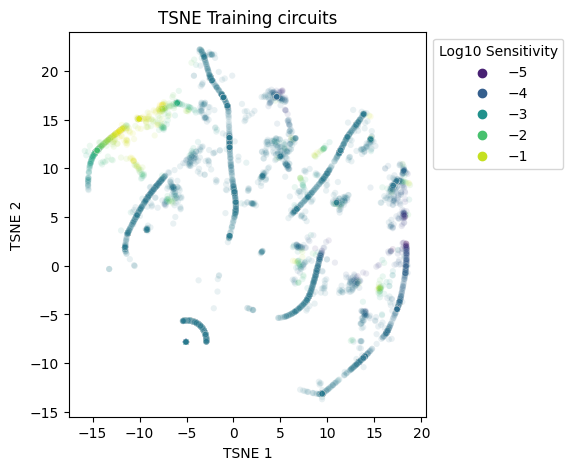

In [ ]:
fig = plt.figure(figsize=(12, 5))
fig.subplots_adjust(wspace=0.6)
# for i in range(n_components):
#     for j in range(i, n_components):
tsne_result_df = pd.DataFrame({'TSNE 1': tsne_result2[:, 0], 'TSNE 2': tsne_result2[:, 1], 'Log10 Sensitivity': np.log10(data[filt][target_circ_func].iloc[:len(tsne_result2)])})
ax = plt.subplot(1,int(factorial(n_components)),1)
sns.scatterplot(x='TSNE 1', y='TSNE 2', hue='Log10 Sensitivity', data=tsne_result_df, s=20, palette='viridis', alpha=0.1)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title('TSNE Training circuits')
